# importing libraries

In [ ]:
import numpy as np
from scipy.linalg import expm
from scipy.signal import cont2discrete
from scipy.signal import StateSpace
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from numpy.linalg import multi_dot, inv
from scipy.signal import dstep

# constants

In [ ]:
T0 = 400 #K
Fs = 1.67 #L/s
kA = 5000 #1/s
kB = 1e+6 #1/s
Eb = 1.5e+4 #cal/mol
Ea = 1e+4 #cal/mol
R = 1.987 #cal/(mol K)
delta_H = -5000 #cal/mol
rho = 1 #kg/L
Cp = 1000 #cal/(kg K)
CA0 = 1 #mol/L
V = 100 #L
CAs = 0.4977 #mol/L
CBs = 0.5023 #mol/L
Ts = 426.743 #K
Qs = 40386 #cal/s

delta_t = 0.1

# simulating ODE system

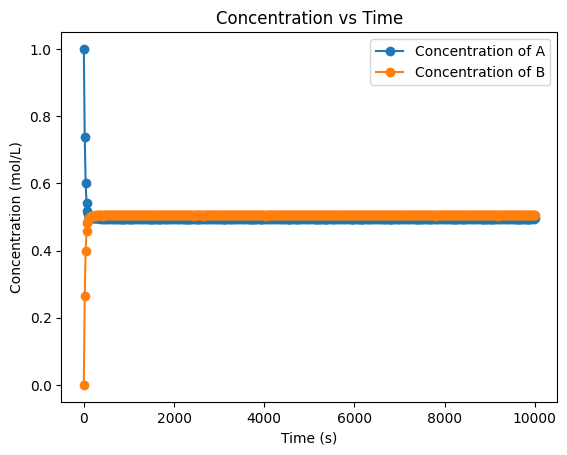

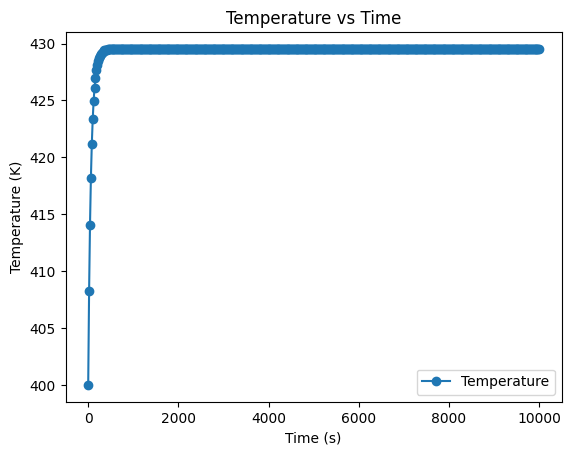

Final Steady State values:
ca = 0.4953109736193115
cb = 0.5046890263806886
T = 429.5227315635297


In [ ]:
ca0 = 1
H = 7e-6
Ea = 1e4
Eb = 1.5e4
R = 1.987
del_H = -5000
rho = 1
Cp = 1000
T0 = 400
V = 100
F = 1.67
tau = V/F
kA = 5000
kB = 1e6
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def cstr(t,D):
    ca,cb,T = D
    dcadt = (1/tau) * (ca0 - ca) - kA * np.exp(-Ea/(R * T)) * ca + kB * np.exp(-Eb/(R * T)) * cb
    dcbdt = (-1/tau) * (cb) + kA * np.exp(-Ea/(R * T)) * ca - kB * np.exp(-Eb/(R * T)) * cb
    dTdt  = -del_H/(rho * Cp) * + kA * np.exp(-Ea/(R * T)) * ca - kB * np.exp(-Eb/(R * T)) * cb + (1/tau) * (T0 - T) + 40386/(rho * Cp * V)
    return [dcadt,dcbdt,dTdt]

sol = solve_ivp(cstr,[0,10000],[1,0,400],t_eval = np.linspace(0,10000,501))

# Plot the concentration vs time
plt.plot(sol.t, sol.y[0], 'o-', label='Concentration of A')
plt.plot(sol.t, sol.y[1], 'o-', label='Concentration of B')

plt.title('Concentration vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/L)')
plt.legend()
plt.show()

# Plot the temperature vs time
plt.plot(sol.t, sol.y[2], 'o-', label='Temperature')

plt.title('Temperature vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

# Print the final values of ca, cb, and T
print('Final Steady State values:')
print('ca =', sol.y[0][-1])
print('cb =', sol.y[1][-1])
print('T =', sol.y[2][-1])

# continuous state space model

In [ ]:
#Calculation of matrix A and B
df1_dA = -(Fs/V) - kA * np.exp(-Ea/(R * Ts))

df3_dA = -(delta_H/(rho * Cp)) * kA * np.exp(-Ea/(R * Ts))

df1_dB = kB * np.exp(-Eb/(R * Ts))
df2_dB = -(Fs/V) - kB * np.exp(-Eb/(R * Ts))
df3_dB = -(delta_H/(rho * Cp)) * kB * np.exp(-Eb/(R * Ts))

df1_dT = - kA * np.exp(-Ea/(R * Ts)) * CAs * (-Ea/(R * Ts *Ts)) + kB * np.exp(-Eb/(R * Ts)) * CBs * (-Eb/(R * Ts *Ts))
df2_dT = kA * np.exp(-Ea/(R * Ts)) * CAs * (-Ea/(R * Ts *Ts)) - kB * np.exp(-Eb/(R * Ts)) * CBs * (-Eb/(R * Ts *Ts))
df3_dT = (kA * np.exp(-Ea/(R * Ts)) * CAs * (-Ea/(R * Ts *Ts)) - kB * np.exp(-Eb/(R * Ts)) * CBs * (-Eb/(R * Ts *Ts))) * (-(delta_H/(rho * Cp))) + (Fs/V) * (-Ts)

A = np.array([[df1_dA,  df3_dA], [df1_dT, df3_dT]]).T

df1_dF = (CA0 - CAs)/V
df3_dF = (T0 - Ts)/V

df1_dQ = 0
df3_dQ = 1/(rho*Cp*V)

B = np.array([[df1_dQ,  df3_dQ], [df1_dF,  df3_dF]]).T

C=np.eye(2)
D=np.zeros((2, 2))

In [ ]:
print(f'{A}\n\n{B}\n\n{C}\n\n{D}')


[[-5.44746460e-02  8.71782395e-05]
 [ 1.88873230e-01 -7.12704399e+00]]

[[ 0.0000e+00  5.0230e-03]
 [ 1.0000e-05 -2.6743e-01]]

[[1. 0.]
 [0. 1.]]

[[0. 0.]
 [0. 0.]]


# discretization

In [ ]:
sys = cont2discrete((A,B,C,D), delta_t, method='zoh')
phi = sys[0]
gamma = sys[1]
C = sys[2]
D = sys[3]

In [ ]:
print(f'{phi}\n\n{gamma}\n\n{C}\n\n{D}')

[[9.94567411e-01 6.21552218e-06]
 [1.34660410e-02 4.90316443e-01]]

[[ 3.47773917e-12  5.00841357e-04]
 [ 7.15140278e-07 -1.91212118e-02]]

[[1. 0.]
 [0. 1.]]

[[0. 0.]
 [0. 0.]]


# step response model

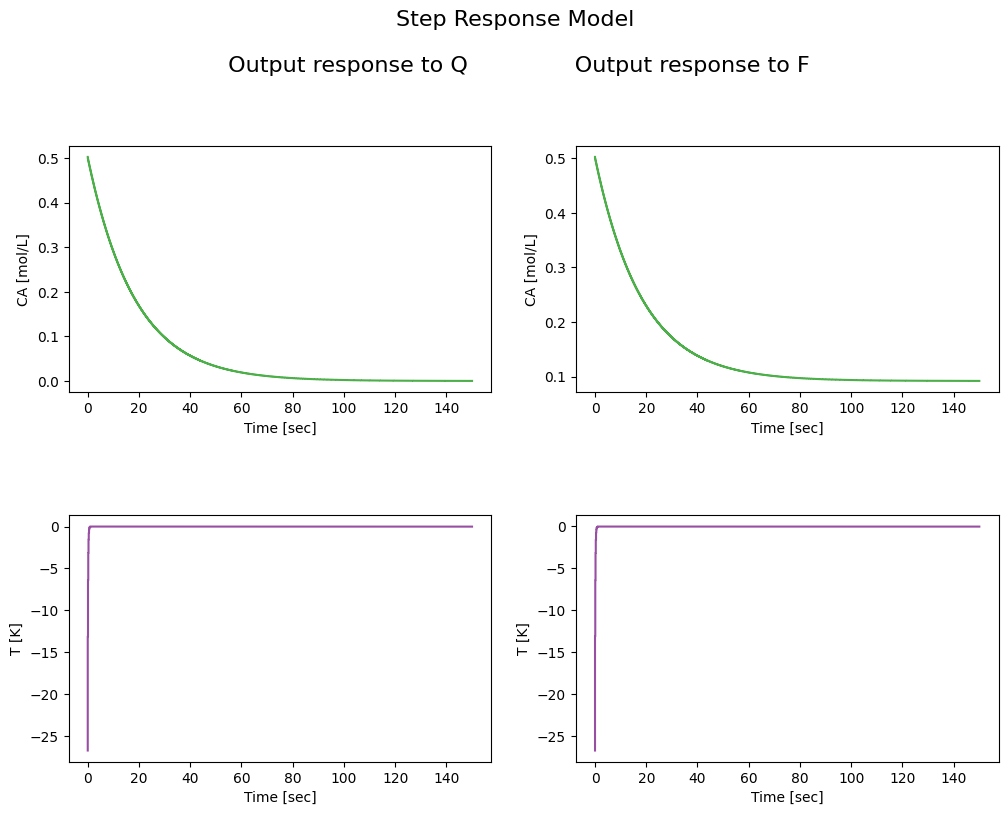

In [ ]:
N = 1500
sysd = (phi, gamma,C,D,delta_t)

t_step, y_step = dstep(sysd,n = N+1, x0= np.array([CA0-CAs, T0-Ts]))
u1, u2  =np.asarray(y_step)
# print(np.shape(u1))
CA_u1, T_u1 = u1[:,0], u1[:,1]
CA_u2, T_u2 = u2[:,0], u2[:,1]

label = ['CA [mol/L]',  'T [K]']
colors = cm.Set1(np.linspace(0, 1, 10))

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for i in range(2):
    axs[i, 0].set_ylabel(label[i])
    axs[i, 1].set_ylabel(label[i])

for j, u in enumerate((u1, u2)):
    for i in range(2):
        axs[i, j].step(t_step, u[:, i], color=colors[(i+2)])
        axs[i, j].set_xlabel('Time [sec]')

fig.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots
fig.suptitle('Step Response Model \n\n Output response to Q               Output response to F ', fontsize=16, y=1.05)
plt.show()


# DMC


In [ ]:
def DMC(A, B, C, D,N,P,M,w,del_t, T, CA,t_f=1000):
    Phi, Gamma, C, D, delta_t = cont2discrete((A, B, C, D), del_t)

    sysd = (Phi, Gamma, C, D, del_t)

    t_step, y_step = dstep(sysd, n=N+1)  # Step response of the discrete-time system
    arr_y_step = np.asarray(y_step)

    y_step_11 = arr_y_step[0,:,0]
    y_step_12 = arr_y_step[0,:,1]

    y_step_21 = arr_y_step[1,:,0]
    y_step_22 = arr_y_step[1,:,1]

    W=w*np.eye((M))
    r=np.ones((P,1))

    S_f_11 = np.zeros((P,M))
    S_f_12 = np.zeros((P,M))
    S_f_21 = np.zeros((P,M))
    S_f_22 = np.zeros((P,M))

    S_f_11[:,0] = y_step_11[1:P+1].T
    S_f_12[:,0] = y_step_12[1:P+1].T
    S_f_21[:,0] = y_step_21[1:P+1].T
    S_f_22[:,0] = y_step_22[1:P+1].T

    for i in range(1,M,1):
        a=np.zeros((i))
        b=y_step_11[1:P+1-i]
        S_f_11[:,i]=np.hstack((a,b)).T

    for i in range(1,M,1):
        a=np.zeros((i))
        b=y_step_12[1:P+1-i]
        S_f_12[:,i]=np.hstack((a,b)).T

    for i in range(1,M,1):
        a=np.zeros((i))
        b=y_step_21[1:P+1-i]
        S_f_21[:,i]=np.hstack((a,b)).T

    for i in range(1,M,1):
        a=np.zeros((i))
        b=y_step_22[1:P+1-i]
        S_f_22[:,i]=np.hstack((a,b)).T


    S_past_11=np.zeros((P,N-2))
    S_past_12=np.zeros((P,N-2))
    S_past_21=np.zeros((P,N-2))
    S_past_22=np.zeros((P,N-2))

    y_step_11_aug=np.hstack((y_step_11[1:N],np.zeros((P-1)))).T
    y_step_12_aug=np.hstack((y_step_12[1:N],np.zeros((P-1)))).T
    y_step_21_aug=np.hstack((y_step_21[1:N],np.zeros((P-1)))).T
    y_step_22_aug=np.hstack((y_step_22[1:N],np.zeros((P-1)))).T

    S_past_11[:,0]=y_step_11_aug[1:P+1]
    S_past_12[:,0]=y_step_12_aug[1:P+1]
    S_past_21[:,0]=y_step_21_aug[1:P+1]
    S_past_22[:,0]=y_step_22_aug[1:P+1]

    for i in range(1,N-2,1):
        S_past_11[:,i]=y_step_11_aug[i+1:P+1+i]
        S_past_12[:,i]=y_step_12_aug[i+1:P+1+i]
        S_past_21[:,i]=y_step_21_aug[i+1:P+1+i]
        S_past_22[:,i]=y_step_22_aug[i+1:P+1+i]

    S_N_11 = y_step_11[N]
    S_N_12 = y_step_12[N]
    S_N_21 = y_step_21[N]
    S_N_22 = y_step_22[N]


    u_past_1=np.zeros(N-1)
    u_past_2=np.zeros(N-1)

    r_1=np.ones((P,1))*T
    r_2=np.ones((P,1))*CA

    d_hat_1=np.zeros((P,round(t_f/delta_t)+1))
    d_hat_2=np.zeros((P,round(t_f/delta_t)+1))

    y_hat_1=np.zeros((1,round(t_f/delta_t)+1))
    error_1=np.zeros((1,round(t_f/delta_t)+1))

    y_hat_2=np.zeros((1,round(t_f/delta_t)+1))
    error_2=np.zeros((1,round(t_f/delta_t)+1))

    u_1=np.zeros((1,round(t_f/delta_t)+1))
    u_2=np.zeros((1,round(t_f/delta_t)+1))
    u=np.zeros((2,round(t_f/delta_t)+1))
    x=np.zeros((2,round(t_f/delta_t)+1))
    y=np.zeros((2,round(t_f/delta_t)+1))
    y_1=np.zeros((1,round(t_f/delta_t)+1))
    y_2=np.zeros((1,round(t_f/delta_t)+1))

    for k in range(0,round(t_f/delta_t),1):
        delta_u_past_1=u_past_1[0:N-2]-u_past_1[1:N-1]
        delta_u_past_2=u_past_2[0:N-2]-u_past_2[1:N-1]

        u_past_flip_1=np.flip(u_past_1)
        u_past_flip_2=np.flip(u_past_2)

        u_p_1=u_past_flip_1[0:P]
        u_p_2=u_past_flip_2[0:P]

        E_1 =(r_1.T-(multi_dot([S_past_11,delta_u_past_1]) + multi_dot([S_past_12,delta_u_past_2]) +S_N_11*u_p_1+d_hat_1[:,k]  + S_N_12*u_p_2)).T
        E_2 =(r_2.T-(multi_dot([S_past_21,delta_u_past_1]) + multi_dot([S_past_22,delta_u_past_2]) +S_N_21*u_p_1+d_hat_2[:,k]  + S_N_22*u_p_2)).T

        delta_u_f_1=multi_dot([inv(multi_dot([S_f_11.T,S_f_11]) + multi_dot([S_f_12.T,S_f_12] )+W),S_f_11.T + S_f_12.T,E_1 ])
        delta_u_f_2=multi_dot([inv(multi_dot([S_f_21.T,S_f_21]) + multi_dot([S_f_22.T,S_f_22] )+W),S_f_21.T + S_f_22.T,E_2])

        if k>0:
            u_1[0,k]=delta_u_f_1[0]+u_1[0,k-1]
            u_1[0,k+1]=u_1[0,k]

            u_2[0,k]=delta_u_f_2[0]+u_2[0,k-1]
            u_2[0,k+1]=u_2[0,k]
        else:
            u_1[0,k]=delta_u_f_1[0]
            u_2[0,k]=delta_u_f_2[0]

        u[:,k] = np.vstack((u_1[0,k],u_2[0,k])).reshape((2,))

        x[:,k+1]=np.dot(Phi,x[:,k])+np.dot(Gamma,u[:,k])
        y[:,k+1]=np.dot(C,x[:,k+1])+np.dot(D,u[:,k+1])

        y_1[:,k+1] = y[0, k+1]
        y_2[:,k+1] = y[1, k+1]

        y_hat_1[:,k+1]=np.dot(S_f_11[0,:],delta_u_f_1)   + np.dot(S_f_12[0,:],delta_u_f_2) + np.dot(S_past_11[0,:],delta_u_past_1)  \
        + np.dot(S_past_12[0,:],delta_u_past_2)  + S_N_11*u_p_1[0] + S_N_12*u_p_2[0]

        y_hat_2[:,k+1]=np.dot(S_f_21[0,:],delta_u_f_1)   + np.dot(S_f_22[0,:],delta_u_f_2) + np.dot(S_past_21[0,:],delta_u_past_1)  \
        + np.dot(S_past_22[0,:],delta_u_past_2)  + S_N_21*u_p_1[0] + S_N_22*u_p_2[0]

        d_hat_1[:,k+1]=np.dot(np.ones((P,1)),y_1[:,k+1]-y_hat_1[:,k+1])
        d_hat_2[:,k+1]=np.dot(np.ones((P,1)),y_2[:,k+1]-y_hat_2[:,k+1])

        u_past_1=np.hstack((u_1[0,k],u_past_1[0:N-2]))
        u_past_2=np.hstack((u_2[0,k],u_past_2[0:N-2]))

        error_1[:,k+1]=r_1[1,0]-y_1[0,k+1]
        error_2[:,k+1]=r_2[1,0]-y_2[0,k+1]

    SSE_1=np.sum(np.square(error_1))
    SSE_2=np.sum(np.square(error_2))
    return SSE_1,SSE_2,y_1,u_1,y_2,u_2


## trying DMC

In [ ]:
P = 8
M = 2
N = 400
del_t = 1
t_f = 1000
w = 1

n_diag = np.zeros((M, M))
np.fill_diagonal(n_diag, 1)
W = w*n_diag
r = np.ones((P,1))

tf_step = N*del_t
t_step = np.linspace(0, tf_step, N+1)


t=np.linspace(0,t_f,round(t_f/del_t)+1)

In [ ]:
SSE_1,SSE_2,y_1,u_1,y_2,u_2 = DMC(A, B, C, D,N,P,M,w,del_t, T0-Ts, CA0-CAs,t_f=1000)

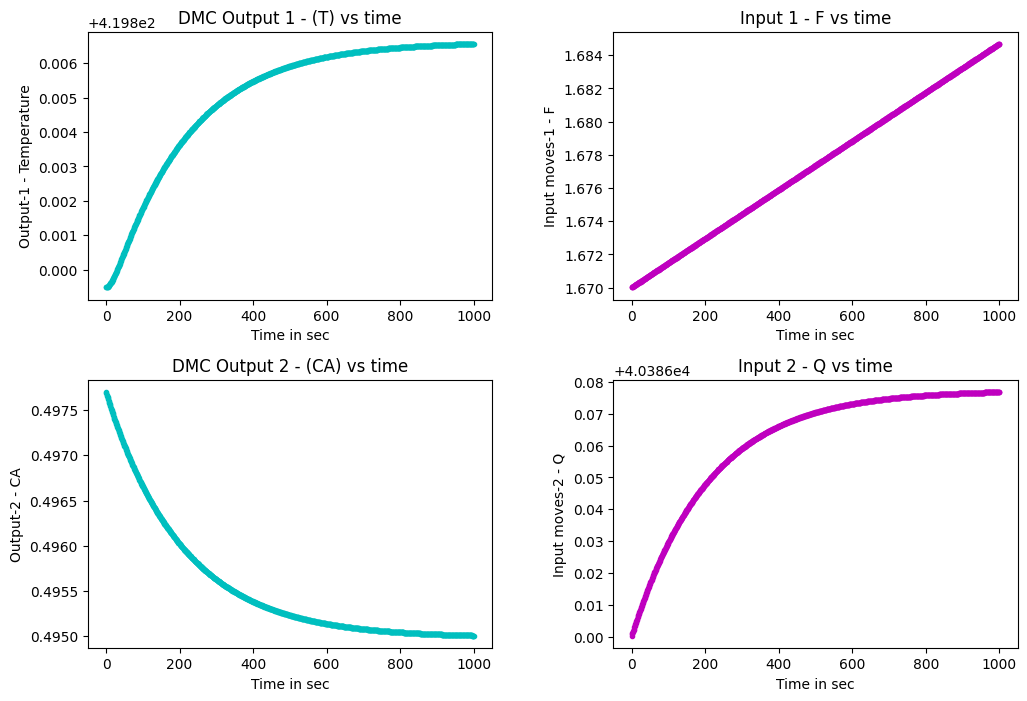

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(t, Ts+y_1[0],"--c.")
axs[0, 0].set_title("DMC Output 1 - (T) vs time")
axs[0, 0].set_ylabel("Output-1 - Temperature")
axs[0, 0].set_xlabel("Time in sec")

axs[0, 1].plot(t, Fs+u_1[0],'--m.')
axs[0, 1].set_title("Input 1 - F vs time")
axs[0, 1].set_ylabel("Input moves-1 - F")
axs[0, 1].set_xlabel("Time in sec")

axs[1, 0].plot(t, CAs+y_2[0],"--c.")
axs[1, 0].set_title("DMC Output 2 - (CA) vs time")
axs[1, 0].set_ylabel("Output-2 - CA")
axs[1, 0].set_xlabel("Time in sec")

axs[1, 1].plot(t, Qs+u_2[0],'--m.')
axs[1, 1].set_title("Input 2 - Q vs time")
axs[1, 1].set_ylabel("Input moves-2 - Q")
axs[1, 1].set_xlabel("Time in sec")

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

# abalation study

## varying P

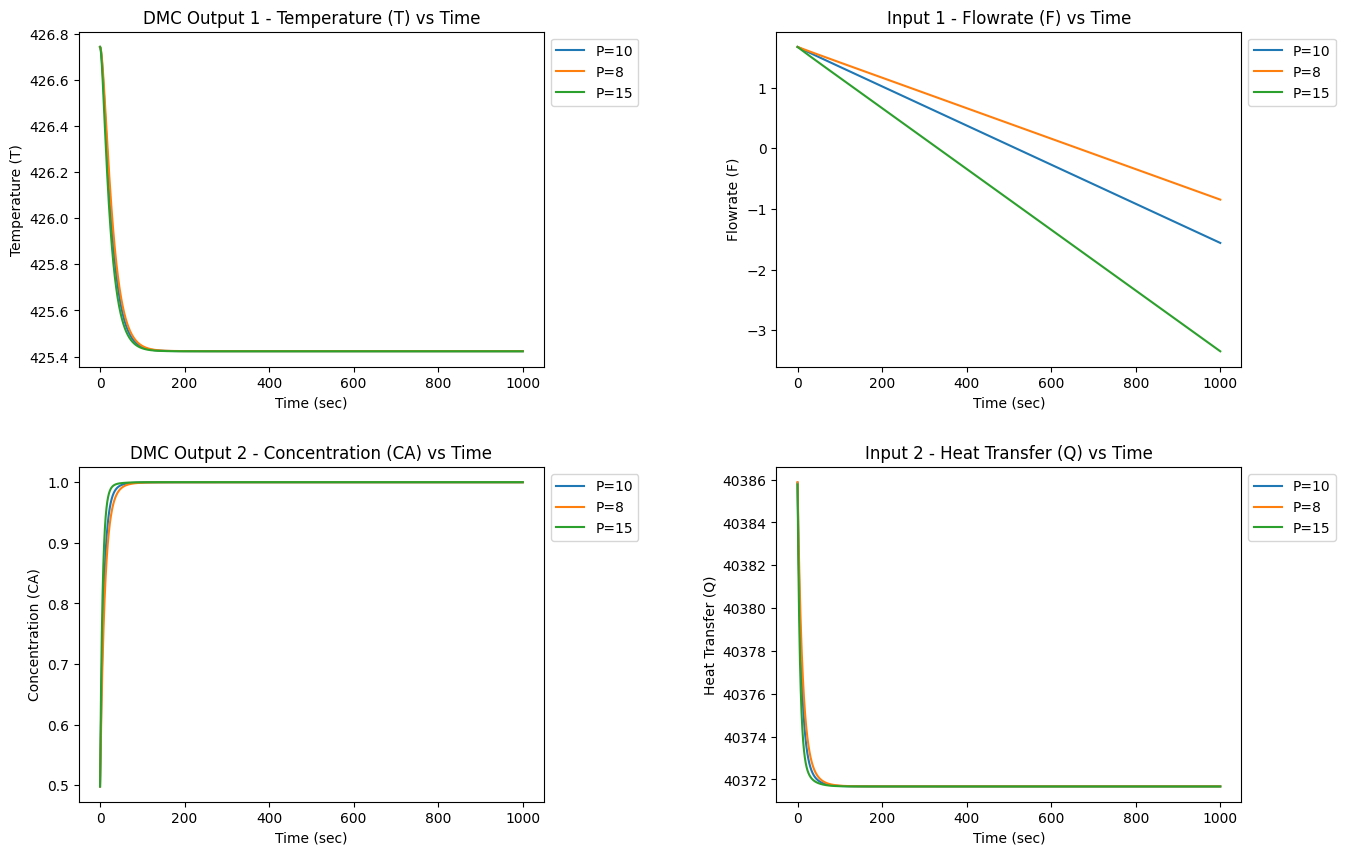

In [ ]:
PH = [10, 8, 15]
CH = [2, 5, 7]
weight = [1, 0.1, 0.01]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
colors = cm.Set1(np.linspace(0, 1, 100))

for P in PH:

  P = P
  M = M
  N = 400
  del_t = 0.1
  t_f = 1000
  w = w

  n_diag = np.zeros((M, M))
  np.fill_diagonal(n_diag, 1)
  W = w*n_diag
  r = np.ones((P,1))

  tf_step = N*del_t
  t_step = np.linspace(0, tf_step, N+1)

  t = np.linspace(0, t_f, round(t_f/del_t)+1)

  SSE_1, SSE_2, y_1, u_1, y_2, u_2 = DMC(A, B, C, D, N, P, M, w, del_t, T0-Ts, CA0-CAs, t_f=1000)

  axs[0, 0].plot(t, Ts+y_1[0], label=f"P={P}")
  axs[0, 0].set_title("DMC Output 1 - Temperature (T) vs Time")
  axs[0, 0].set_ylabel("Temperature (T)")
  axs[0, 0].set_xlabel("Time (sec)")

  axs[0, 1].plot(t, Fs+u_1[0], label=f"P={P}")
  axs[0, 1].set_title("Input 1 - Flowrate (F) vs Time")
  axs[0, 1].set_ylabel("Flowrate (F)")
  axs[0, 1].set_xlabel("Time (sec)")

  axs[1, 0].plot(t, CAs+y_2[0],  label=f"P={P}")
  axs[1, 0].set_title("DMC Output 2 - Concentration (CA) vs Time")
  axs[1, 0].set_ylabel("Concentration (CA)")
  axs[1, 0].set_xlabel("Time (sec)")

  axs[1, 1].plot(t, Qs+u_2[0], label=f"P={P}")
  axs[1, 1].set_title("Input 2 - Heat Transfer (Q) vs Time")
  axs[1, 1].set_ylabel("Heat Transfer (Q)")
  axs[1, 1].set_xlabel("Time (sec)")

  plt.subplots_adjust(wspace=0.5, hspace=0.3)
  axs[0, 0].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
  axs[0, 1].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
  axs[1, 0].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
  axs[1, 1].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))

plt.show()


## varying M

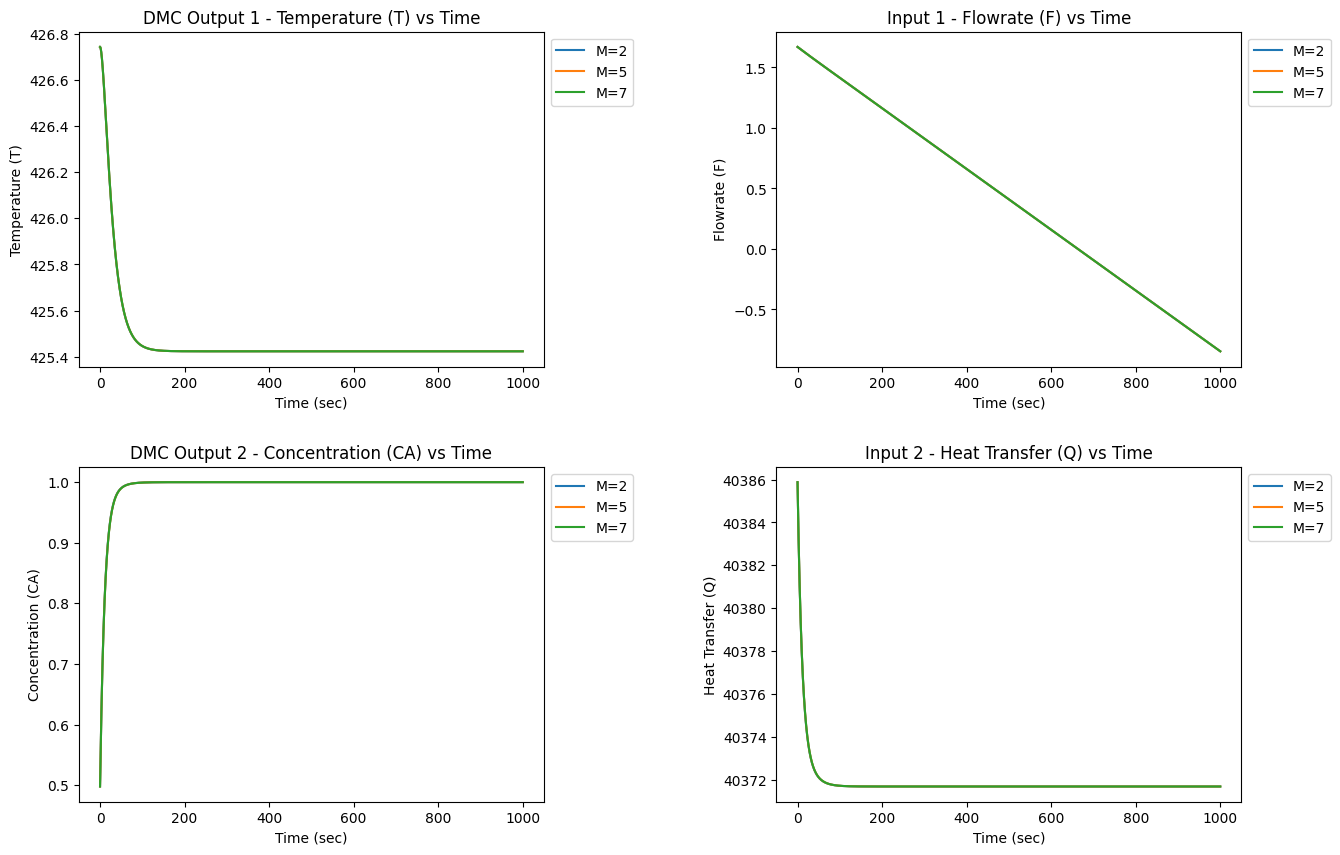

In [ ]:
PH = [10, 8, 15]
CH = [2, 5, 7]
weight = [1, 0.1, 0.01]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
colors = cm.Set1(np.linspace(0, 1, 100))

for M in CH:

  P = PH[1]
  M = M
  N = 400
  del_t = 0.1
  t_f = 1000
  w = w

  n_diag = np.zeros((M, M))
  np.fill_diagonal(n_diag, 1)
  W = w*n_diag
  r = np.ones((P,1))

  tf_step = N*del_t
  t_step = np.linspace(0, tf_step, N+1)

  t = np.linspace(0, t_f, round(t_f/del_t)+1)

  SSE_1, SSE_2, y_1, u_1, y_2, u_2 = DMC(A, B, C, D, N, P, M, w, del_t, T0-Ts, CA0-CAs, t_f=1000)

  axs[0, 0].plot(t, Ts+y_1[0], label=f"M={M}")
  axs[0, 0].set_title("DMC Output 1 - Temperature (T) vs Time")
  axs[0, 0].set_ylabel("Temperature (T)")
  axs[0, 0].set_xlabel("Time (sec)")

  axs[0, 1].plot(t, Fs+u_1[0], label=f"M={M}")
  axs[0, 1].set_title("Input 1 - Flowrate (F) vs Time")
  axs[0, 1].set_ylabel("Flowrate (F)")
  axs[0, 1].set_xlabel("Time (sec)")

  axs[1, 0].plot(t, CAs+y_2[0],  label=f"M={M}")
  axs[1, 0].set_title("DMC Output 2 - Concentration (CA) vs Time")
  axs[1, 0].set_ylabel("Concentration (CA)")
  axs[1, 0].set_xlabel("Time (sec)")

  axs[1, 1].plot(t, Qs+u_2[0], label=f"M={M}")
  axs[1, 1].set_title("Input 2 - Heat Transfer (Q) vs Time")
  axs[1, 1].set_ylabel("Heat Transfer (Q)")
  axs[1, 1].set_xlabel("Time (sec)")

  plt.subplots_adjust(wspace=0.5, hspace=0.3)
  axs[0, 0].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
  axs[0, 1].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
  axs[1, 0].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
  axs[1, 1].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))

plt.show()


## varying w

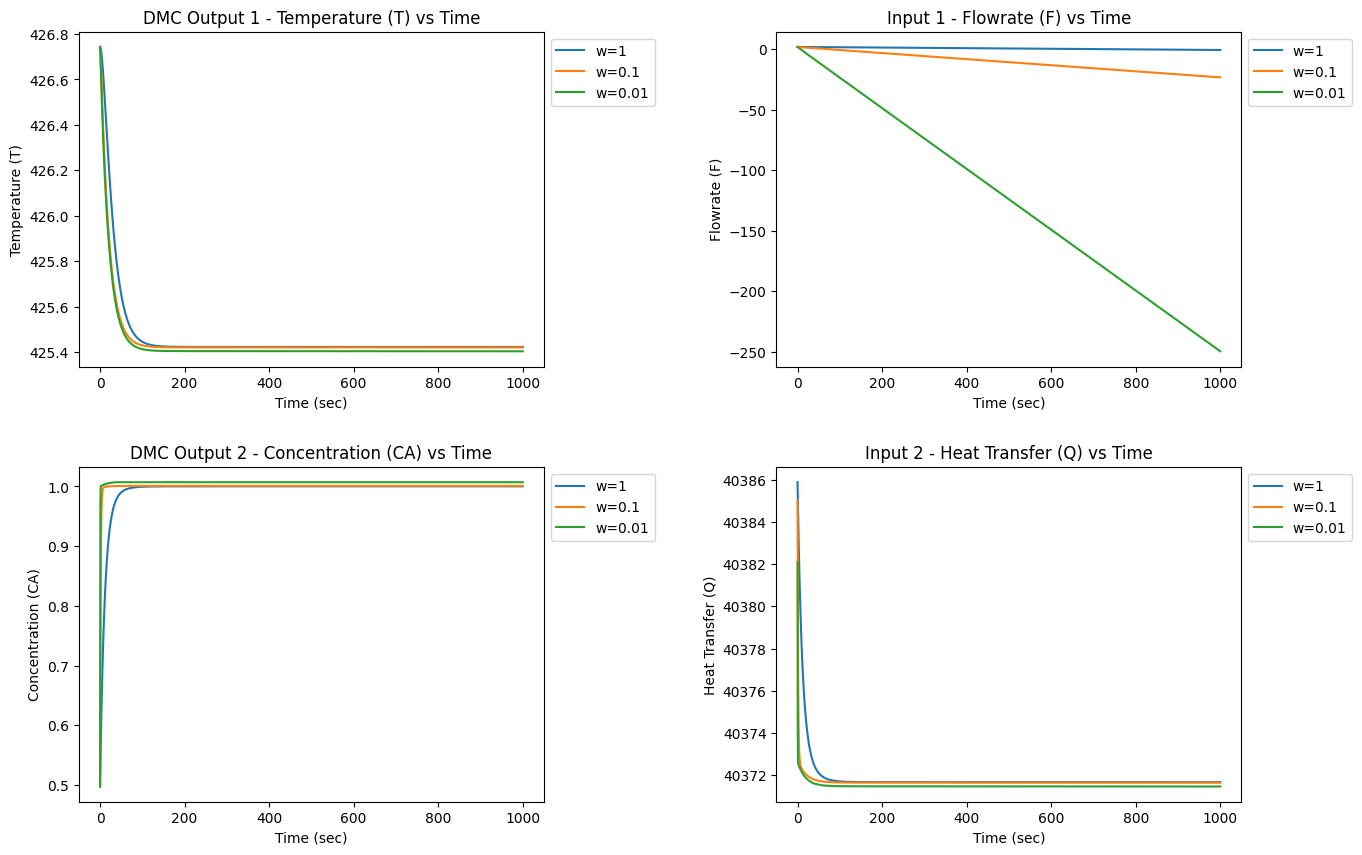

In [ ]:
PH = [10, 8, 15]
CH = [2, 5, 7]
weight = [1, 0.1, 0.01]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
colors = cm.Set1(np.linspace(0, 1, 100))

for w in weight:

  P = P
  M = M
  N = 400
  del_t = 0.1
  t_f = 1000
  w = w

  n_diag = np.zeros((M, M))
  np.fill_diagonal(n_diag, 1)
  W = w*n_diag
  r = np.ones((P,1))

  tf_step = N*del_t
  t_step = np.linspace(0, tf_step, N+1)

  t = np.linspace(0, t_f, round(t_f/del_t)+1)

  SSE_1, SSE_2, y_1, u_1, y_2, u_2 = DMC(A, B, C, D, N, P, M, w, del_t, T0-Ts, CA0-CAs, t_f=1000)

  axs[0, 0].plot(t, Ts+y_1[0], label=f"w={w}")
  axs[0, 0].set_title("DMC Output 1 - Temperature (T) vs Time")
  axs[0, 0].set_ylabel("Temperature (T)")
  axs[0, 0].set_xlabel("Time (sec)")

  axs[0, 1].plot(t, Fs+u_1[0], label=f"w={w}")
  axs[0, 1].set_title("Input 1 - Flowrate (F) vs Time")
  axs[0, 1].set_ylabel("Flowrate (F)")
  axs[0, 1].set_xlabel("Time (sec)")

  axs[1, 0].plot(t, CAs+y_2[0],  label=f"w={w}")
  axs[1, 0].set_title("DMC Output 2 - Concentration (CA) vs Time")
  axs[1, 0].set_ylabel("Concentration (CA)")
  axs[1, 0].set_xlabel("Time (sec)")

  axs[1, 1].plot(t, Qs+u_2[0], label=f"w={w}")
  axs[1, 1].set_title("Input 2 - Heat Transfer (Q) vs Time")
  axs[1, 1].set_ylabel("Heat Transfer (Q)")
  axs[1, 1].set_xlabel("Time (sec)")

  plt.subplots_adjust(wspace=0.5, hspace=0.3)
  axs[0, 0].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
  axs[0, 1].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
  axs[1, 0].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
  axs[1, 1].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))

plt.show()


# real time optimization

In [ ]:
#set points
CA, CB, T = np.array([[  0.50173893,   0.50629083,   0.51016556,   0.51296443,
          0.5159354 ,   0.51748563,   0.51717212,   0.51502601,
          0.51154349,   0.5088307 ],
       [  0.49826107,   0.49370917,   0.48983444,   0.48703557,
          0.4840646 ,   0.48251437,   0.48282788,   0.48497399,
          0.48845651,   0.4911693 ],
       [423.88530838, 421.13487184, 419.14029225, 417.8369626 ,
        416.55127472, 415.91416885, 416.04130969, 416.93529664,
        418.48624088, 419.79948917]])
Q = [3.57279850e+04, 3.11727644e+04, 2.78741705e+04, 2.57209805e+04,
        2.35986894e+04, 2.25476670e+04, 2.27573744e+04, 2.42324126e+04,
        2.67934104e+04, 2.89638833e+04]

In [ ]:
P = 8
M = 2
N = 400
del_t = 1
t_f = 1000
w = 1

n_diag = np.zeros((M, M))
np.fill_diagonal(n_diag, 1)
W = w*n_diag
r = np.ones((P,1))

tf_step = N*del_t
t_step = np.linspace(0, tf_step, N+1)

delta_t = 1
t=np.linspace(0,t_f,round(t_f/del_t)+1)

In [ ]:
SSE1,SSE2,y1,u1,y2,u2 = [], [], [], [], [], []

In [ ]:
for i in range(len(T)):
  if i ==0:
    SSE_1,SSE_2,y_1,u_1,y_2,u_2 = DMC(A, B, C, D,N,P,M,w,delta_t, T[i]-Ts, CA[i]-CAs,t_f=1000)
    print(SSE_1,SSE_2)

    SSE1.append(SSE_1)
    SSE2.append(SSE_2)
    y1.append(y_1[0]+Ts)
    u1.append(u_1[0]+Fs)
    y2.append(y_2[0]+CAs)
    u2.append(u_2[0]+Qs)
  else:
    SSE_1,SSE_2,y_1,u_1,y_2,u_2 = DMC(A, B, C, D,N,P,M,w,delta_t, -T[i-1]+T[i], -CA[i-1]+CA[i],t_f=1000)
    print(SSE_1,SSE_2)

    SSE1.append(SSE_1)
    SSE2.append(SSE_2)
    y1.append(y_1[0]+T[i])
    u1.append(u_1[0]+Fs)
    y2.append(y_2[0]+CA[i])
    u2.append(u_2[0]+Q[i])


8119.3598710856995 0.0016714215701789262
7513.9040144093215 0.0021241092932833172
3946.8854375858728 0.0015398586674359325
1683.8234541299603 0.0008036684122181943
1637.453469062336 0.0009056994105216185
401.88660024437337 0.0002466210833933874
16.00267233115874 1.0086797437590693e-05
791.4084080686467 0.0004726383504594747
2383.451913418261 0.0012443588687965498
1710.1212862792459 0.0007549204510314382


In [ ]:
print(np.shape(T))
print(np.shape(y1))

(10,)
(10, 1001)


In [ ]:
time = []
for i in range(len(T)):
  time.append((i *1000)+t)

In [ ]:
t_new = ((np.array(time).flatten()))
y1_new = ((np.array(y1).flatten()))
y2_new = ((np.array(y2).flatten()))
u1_new = ((np.array(u1).flatten()))
u2_new = ((np.array(u2).flatten()))

In [ ]:
import pyomo.environ as pyo
import numpy as np
import warnings
warnings.filterwarnings('ignore')
m = pyo.ConcreteModel()

m.ca = pyo.Var(bounds=[0, 1], within=pyo.NonNegativeReals)
m.cb = pyo.Var(bounds=[0, 1], within=pyo.NonNegativeReals)
m.Q = pyo.Var(bounds=[0, 1e5], within=pyo.NonNegativeReals)
m.T = pyo.Var(bounds=[400, 500], within=pyo.NonNegativeReals)
# m.H = pyo.Var(within=pyo.NonNegativeReals)

ca0 = 1
H = 7e-7
Ea = 1e4
Eb = 1.5e4
R = 1.987
del_H = -5000
rho = 1
Cp = 1000
T0 = 400
V = 100
F = 1.67
tau = V/F
kA = 5000
kB = 1e6



H = {0:0.7e-6,
    1:0.9e-6,
    2:1.1e-6,
    3:1.25e-6,
    4:1.35e-6,
    5:1.45e-6,
    6:1.5e-6,
    7:1.49e-6,
    8:1.42e-6,
    9:1.3e-6,
    10:1.2e-6
    }

m = pyo.ConcreteModel()

m.ca = pyo.Var(bounds=[0, 1], within=pyo.NonNegativeReals)
m.cb = pyo.Var(bounds=[0, 1], within=pyo.NonNegativeReals)
m.Q = pyo.Var(bounds=[0, 1e5], within=pyo.NonNegativeReals)
m.T = pyo.Var(bounds=[400, 500], within=pyo.NonNegativeReals)



def RTO(h):
    m = pyo.ConcreteModel()

    m.ca = pyo.Var(bounds=[0, 1], within=pyo.NonNegativeReals)
    m.cb = pyo.Var(bounds=[0, 1], within=pyo.NonNegativeReals)
    m.Q = pyo.Var(bounds=[0, 1e5], within=pyo.NonNegativeReals)
    m.T = pyo.Var(bounds=[400, 500], within=pyo.NonNegativeReals)


    m.obj = pyo.Objective(expr=m.ca/ca0 + h * m.Q)
    m.con1 = pyo.Constraint(expr=(1/tau) * (ca0 - m.ca)
                             - kA * pyo.exp(-Ea/(R * m.T)) * m.ca
                             + kB * pyo.exp(-Eb/(R * m.T)) * m.cb == 0)

    m.con2 = pyo.Constraint(expr=(-1/tau) * (m.cb)
                             + kA * pyo.exp(-Ea/(R*m.T)) * m.ca
                             - kB * pyo.exp(-Eb/(R * m.T)) * m.cb == 0)

    m.con3 = pyo.Constraint(expr=-del_H/(rho * Cp)
                             * (kA * pyo.exp(-Ea/(R*m.T)) * m.ca
                             - kB * pyo.exp(-Eb/(R * m.T)) * m.cb)
                             + (1/tau) * (T0 - m.T) + m.Q/(rho * Cp * V)
                             == 0)

    opt = pyo.SolverFactory('gams:IPOPT')
    sol = opt.solve(m)


    return m.ca.value, m.cb.value, m.T.value,m.Q.value
Set_points = []
TS = []
CAS = []
QS = []
for i in range(11):
    cas,cbs,Ts,Q = RTO(H[i])
    Set_points.append([cas,cbs,Ts])
    TS.append(Ts)
    CAS.append(cas)
    QS.append(Q)
    print(cas,cbs,Ts,Q)

Set_points


0.497918466772853 0.502081533227147 426.7672022400684 40508.846938467585
0.501738927609917 0.498261072390083 423.885308375162 35727.9850320634
0.506290830501389 0.493709169498611 421.13487183976343 31172.764407091574
0.51016556078148 0.48983443921852 419.14029224540377 27874.17048234963
0.512964426431707 0.487035573568293 417.83696259835756 25720.980499961883
0.515935399994618 0.484064600005382 416.55127471849096 23598.689369835058
0.5174856318565 0.4825143681435 415.9141688494266 22547.667004544168
0.517172119532135 0.482827880467865 416.04130968965234 22757.37437981288
0.515026013220766 0.484973986779234 416.93529663735154 24232.412594770536
0.51154349286919 0.48845650713081 418.48624087915 26793.410433638233
0.508830701569546 0.491169298430454 419.7994891696853 28963.883271480147


[[0.497918466772853, 0.502081533227147, 426.7672022400684],
 [0.501738927609917, 0.498261072390083, 423.885308375162],
 [0.506290830501389, 0.493709169498611, 421.13487183976343],
 [0.51016556078148, 0.48983443921852, 419.14029224540377],
 [0.512964426431707, 0.487035573568293, 417.83696259835756],
 [0.515935399994618, 0.484064600005382, 416.55127471849096],
 [0.5174856318565, 0.4825143681435, 415.9141688494266],
 [0.517172119532135, 0.482827880467865, 416.04130968965234],
 [0.515026013220766, 0.484973986779234, 416.93529663735154],
 [0.51154349286919, 0.48845650713081, 418.48624087915],
 [0.508830701569546, 0.491169298430454, 419.7994891696853]]

Text(0.5, 1.0, 'output temperature behaviour with time')

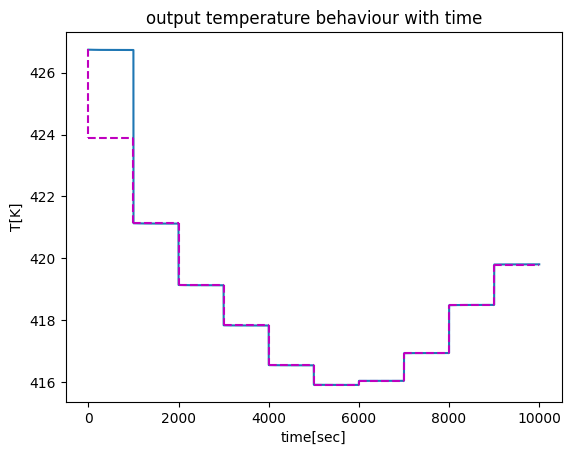

In [ ]:
i = 0
plt.step(t_new, y1_new)
while (i<10):
#     if (i>0):
    ts =TS[i+1]
    t_rto = np.linspace(i *1000,(i+1)*1000,500)
    y = ts * np.ones(np.shape(t_rto))
    plt.plot(i * 1000 * np.ones(np.shape(t_rto)), np.linspace(TS[i],TS[i+1],500),'m--')
    plt.plot(t_rto,y,'m--')
    i=i+1

plt.ylabel('T[K]')
plt.xlabel('time[sec]')
plt.title("output temperature behaviour with time")


Text(0.5, 1.0, 'output CA behaviour with time')

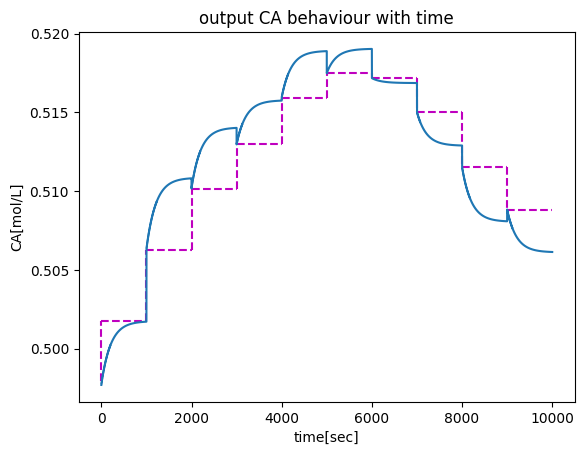

In [ ]:
i = 0

while (i<10):
#     if (i>0):
    ca = CAS[i+1]
    t_rto = np.linspace(i *1000,(i+1)*1000,500)
    y = ca * np.ones(np.shape(t_rto))
    plt.plot(i * 1000 * np.ones(np.shape(t_rto)), np.linspace(CAS[i],CAS[i+1],500),'m--')
    plt.plot(t_rto,y,'m--')
    i=i+1
plt.step(t_new, y2_new)
plt.ylabel('CA[mol/L]')
plt.xlabel('time[sec]')
plt.title("output CA behaviour with time")

Text(0.5, 1.0, 'heat input with time')

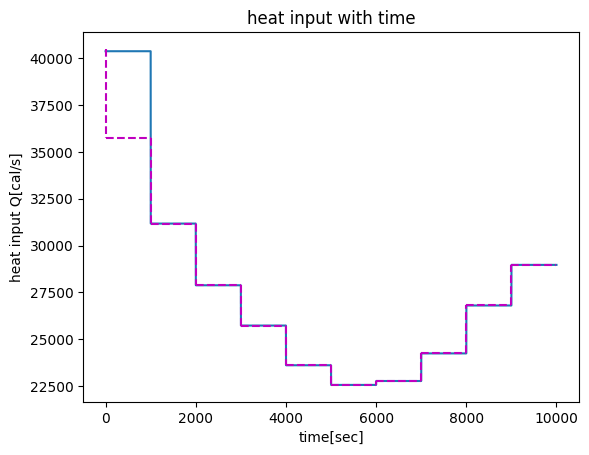

In [ ]:

i = 0
plt.step(t_new, u2_new)
while (i<10):
#     if (i>0):
    q = QS[i+1]
    t_rto = np.linspace(i *1000,(i+1)*1000,500)
    y = q * np.ones(np.shape(t_rto))
    plt.plot(i * 1000 * np.ones(np.shape(t_rto)), np.linspace(QS[i],QS[i+1],500),'m--')
    plt.plot(t_rto,y,'m--')
    i=i+1

plt.ylabel('heat input Q[cal/s]')
plt.xlabel('time[sec]')
plt.title("heat input with time")

Text(0.5, 1.0, 'Heat price variation with time')

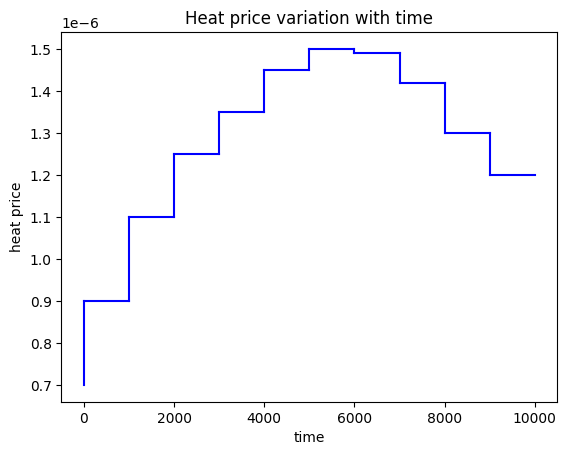

In [ ]:
import matplotlib.pyplot as plt

i = 0
import matplotlib.pyplot as plt

i = 0

while (i<10):
#     if (i>0):
    h = H[i+1]
    t_rto = np.linspace(i *1000,(i+1)*1000,500)
    y = h * np.ones(np.shape(t_rto))
    plt.plot(i * 1000 * np.ones(np.shape(t_rto)), np.linspace(H[i],H[i+1],500),'b')
    plt.plot(t_rto,y,'b')
    i=i+1
plt.xlabel('time')
plt.ylabel("heat price")
plt.title("Heat price variation with time")


In [ ]:
t_price = []
for i in range(10):
    price = y2[i]+(H[i]*y1[i])

    t_price.append(price)

In [ ]:
cost = (np.array(t_price)).flatten()

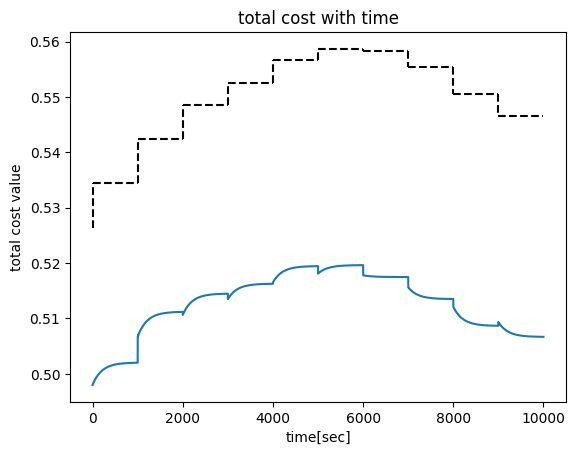

In [ ]:
def tc(cas,qs,hs):
    t_c = (cas/ca0) + (hs * qs)
    return t_c

TC=[]
TC1=[]
for i in range(11):
    TC.append(tc(CAS[0],QS[0],H[i]))


import matplotlib.pyplot as plt

i = 0

while (i<10):
#     if (i>0):
    tcs = TC[i+1]
    t_rto = np.linspace(i *1000,(i+1)*1000,500)
    y = tcs * np.ones(np.shape(t_rto))
    plt.plot(i * 1000 * np.ones(np.shape(t_rto)), np.linspace(TC[i],TC[i+1],500),'k--')
    plt.plot(t_rto,y,'k--')
    i=i+1

for i in range(11):
    TC1.append(tc(CAS[i],QS[i],H[i]))

i = 0

plt.step(t_new, cost)
plt.title("total cost with time")
plt.ylabel("total cost value")
plt.xlabel("time[sec]")
plt.show();